In [1]:
# gdrive mount
from google.colab import drive
drive.mount('/content/gdrive', force_remount = True)

Mounted at /content/gdrive


In [ ]:
import pandas as pd 
import os
import numpy as np 
import matplotlib.pyplot as plt 

import pickle
import tensorflow as tf
from tensorflow.keras.models import load_model

from sklearn.metrics import *
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score, cross_val_predict

In [ ]:
def data_info(direct):
  files = [file.strip() for file in os.listdir(direct)]
  filenames = []     
  for file in files:
    add = [file[:-4],file[0]]
    filenames.append(add)
  return filenames

In [ ]:
# train, test
df_train = data_info("/content/gdrive/MyDrive/Fingerprint-Recognition/data/train")
df_test = data_info("/content/gdrive/MyDrive/Fingerprint-Recognition/data/test")

train = pd.DataFrame(df_train, columns =['filename', 'label']) 
test = pd.DataFrame(df_test, columns = ['filename', 'label'])   # test data에서 label 값 의미 없는 값(실제 라벨 값 아님) -> predict 후 바꿔줄것
display(train.head(), test.head())

filename label
0    7 (5)     7
1    7 (6)     7
2    2 (6)     2
3    3 (6)     3
4    7 (4)     7

filename label
0       41     4
1       45     4
2        2     2
3        1     1
4       44     4

In [ ]:
print('train:', len(train))
print('test:', len(test))

train: 80
test: 80


In [ ]:
def pixel_info(direct, df):
  pixels = []
  for file in list(df['filename']):
    from PIL import Image
    im = Image.open(direct+'/'+file+'.bmp')
    pix = list(im.getdata())
    pixels.append(pix)

  df_pix = pd.DataFrame(pixels, columns = list(range(144**2)))
  return df_pix

In [ ]:
train_pix = pixel_info('/content/gdrive/MyDrive/Fingerprint-Recognition/data/train', train)
test_pix = pixel_info('/content/gdrive/MyDrive/Fingerprint-Recognition/data/test', test)

In [ ]:
display(train_pix.head(), test_pix.head())

0      1      2      3      4      5      6      7      8      9      ...  \
0      0      0      0      0      0      0      0      0      0      0  ...   
1      0      0      0      0      0      0      0      0      0      0  ...   
2      0      0      0      0      0      0      0      0      0      0  ...   
3      0      0      0      0      0      0      0      0      0      0  ...   
4      0      0      0      0      0      0      0      0      0      0  ...   

   20726  20727  20728  20729  20730  20731  20732  20733  20734  20735  
0      0      0      0      0      0      0      0      0      0      0  
1      0      0      0      0      0      0      0      0      0      0  
2      0      0      0      0      0      0      0      0      0      0  
3      0      0      0      0      0      0      0      0      0      0  
4      0      0      0      0      0      0      0      0      0      0  

[5 rows x 20736 columns]

0      1      2      3      4      5      6      7      8      9      ...  \
0      0      0      0      0      0      0      0      0      0      0  ...   
1      0      0      0      0      0      0      0      0      0      0  ...   
2      0      0      0      0      0      0      0      0      0      0  ...   
3      0      0      0      0      0      0      0      0      0      0  ...   
4      0      0      0      0      0      0      0      0      0      0  ...   

   20726  20727  20728  20729  20730  20731  20732  20733  20734  20735  
0      0      0      0      0      0      0      0      0      0      0  
1      0      0      0      0      0      0      0      0      0      0  
2      0      0      0      0      0      0      0      0      0      0  
3      0      0      0      0      0      0      0      0      0      0  
4      0      0      0      0      0      0      0      0      0      0  

[5 rows x 20736 columns]

In [ ]:
import imageio
import glob
list_dirs_te = list(glob.glob("/content/gdrive/MyDrive/Fingerprint-Recognition/data/test/*.bmp"))
list_dirs_tr = list(glob.glob("/content/gdrive/MyDrive/Fingerprint-Recognition/data/train/*.bmp"))
num_images_te = len(list_dirs_te)
num_images_tr = len(list_dirs_tr)
img_te = [None]*num_images_te
img_tr = [None]*num_images_tr

for i in range(num_images_tr):
  img_tr[i] = imageio.imread(list_dirs_tr[i])

for i in range(num_images_te):
  img_te[i] = imageio.imread(list_dirs_te[i])

import cv2
for i in range(num_images_tr):
  img_tr[i] = cv2.medianBlur(img_tr[i],1)

for i in range(num_images_te):
  img_te[i] = cv2.medianBlur(img_te[i],1)

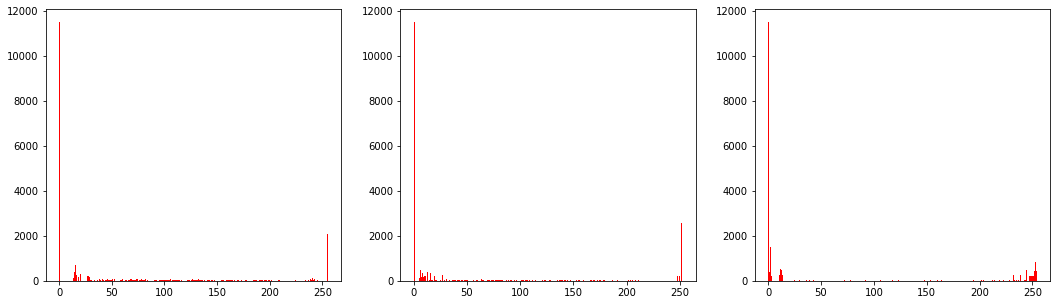

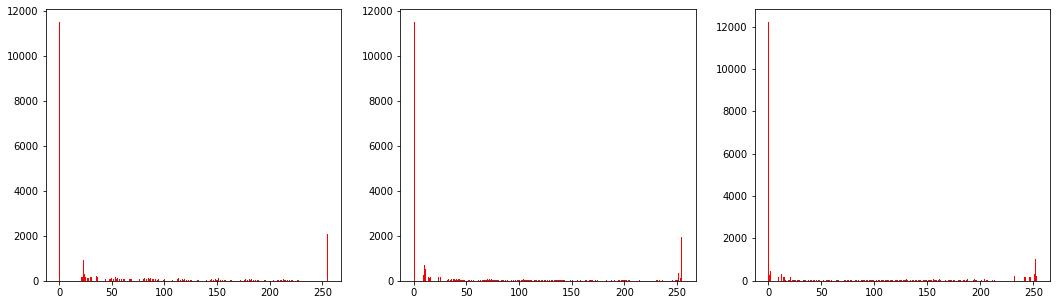

In [ ]:
fig1, axes1 = plt.subplots(1,3,figsize = (18,5))
for i in range(3):
  axes1[i].hist(img_te[i].ravel(), bins=256, color ="r")
fig2, axes2 = plt.subplots(1,3,figsize = (18,5))
for i in range(3):
  axes2[i].hist(img_tr[i].ravel(), bins=256, color ="r")  

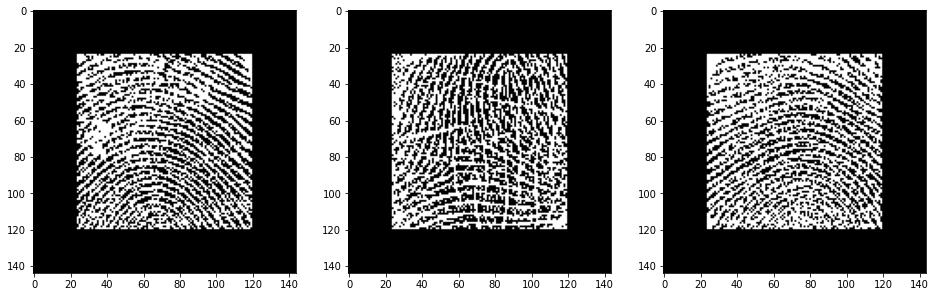

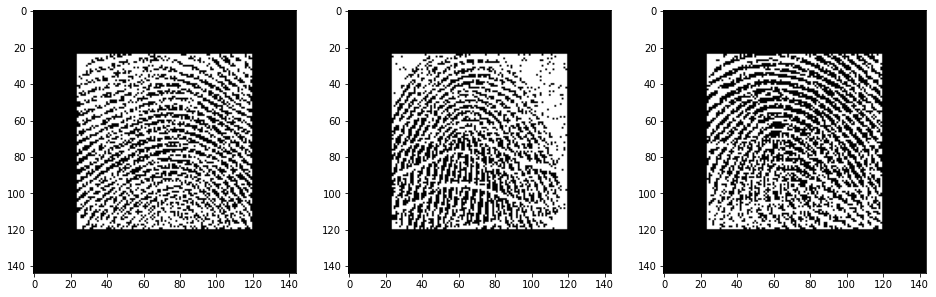

In [ ]:
Thresh_te =[None] * num_images_te

for i in range(num_images_te):
  Thresh_te[i] = img_te[i].mean()
  img_te[i] = np.array(img_te[i] > Thresh_te[i]).astype(int) * 255

fig, axes = plt.subplots(1,3,figsize = (16,16));
axes[0].imshow(img_te[1],cmap="gray");
axes[1].imshow(img_te[2],cmap="gray");
axes[2].imshow(img_te[3],cmap="gray");

Thresh_tr =[None] * num_images_tr

for i in range(num_images_tr):
  Thresh_tr[i] = img_tr[i].mean()
  img_tr[i] = np.array(img_tr[i] > Thresh_tr[i]).astype(int) * 255

fig, axes = plt.subplots(1,3,figsize = (16,16));
axes[0].imshow(img_tr[1],cmap="gray");
axes[1].imshow(img_tr[2],cmap="gray");
axes[2].imshow(img_tr[3],cmap="gray");

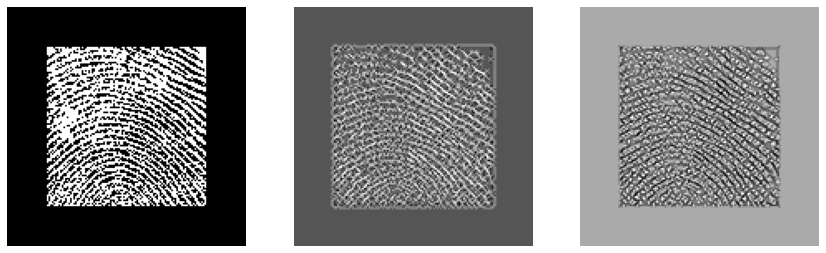

In [ ]:
from skimage.feature import hessian_matrix, hessian_matrix_eigvals
def detect_ridges(gray, sigma= 0.1):
    H_elems = hessian_matrix(gray, sigma=sigma, order='rc')
    maxima_ridges, minima_ridges = hessian_matrix_eigvals(H_elems)
    return maxima_ridges, minima_ridges

def plot_images(*images):
    images = list(images)
    n = len(images)
    fig, ax = plt.subplots(ncols=n, sharey=True, figsize = (12,12))
    for i, img in enumerate(images):
        ax[i].imshow(img, cmap='gray')
        ax[i].axis('off')
    plt.subplots_adjust(left=0.03, bottom=0.03, right=0.97, top=0.97)
    plt.show()


for i in range(num_images_tr):
  a_tr, b_tr = detect_ridges(img_tr[i], sigma=0.15)

for i in range(num_images_te):
  a_te, b_te = detect_ridges(img_te[i], sigma=0.15)

plot_images(img_te[1], a_te, b_te)

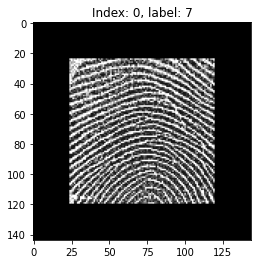

In [ ]:
idx = 0
img = train_pix.loc[idx, '0':].values.reshape(144, 144).astype(int)
label = train.loc[idx, 'label']

plt.title('Index: %i, label: %s'%(idx, label))
plt.imshow(img,cmap="gray")
plt.show()

Train-Test-Split

In [ ]:
X_train, X_val, y_train, y_val = train_test_split(train_pix.values, train['label'], test_size = 0.5, random_state=42, shuffle=True, stratify=None)

Random Forest Classifier Model

In [ ]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier()
rf.fit(X_train, y_train)

RandomForestClassifier()

In [ ]:
scores = cross_val_score(rf, X_train, y_train, cv = 3, scoring = 'accuracy')
print("Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:680: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=3.
  UserWarning,


Accuracy: 0.95 (+/- 0.07)


Save Model

In [ ]:
with open('/content/gdrive/MyDrive/Fingerprint-Recognition/model/model_cb.pkl','wb') as f:
    pickle.dump(rf,f)

Load Model

In [ ]:
with open('/content/gdrive/MyDrive/Fingerprint-Recognition/model/model_cb.pkl', 'rb') as f:
    best = pickle.load(f)

In [ ]:
# K = 3 validation score 
val_pred = best.predict(X_val)
acc = (val_pred == y_val).mean()
print("Accuracy: %0.2f" % (acc))

Accuracy: 0.97


In [ ]:
print(classification_report(y_val ,val_pred))

              precision    recall  f1-score   support

           1       1.00      1.00      1.00         4
           2       1.00      1.00      1.00         3
           3       1.00      0.83      0.91         6
           4       0.83      1.00      0.91         5
           5       1.00      1.00      1.00         6
           6       1.00      1.00      1.00         5
           7       1.00      1.00      1.00         3
           8       1.00      1.00      1.00         8

    accuracy                           0.97        40
   macro avg       0.98      0.98      0.98        40
weighted avg       0.98      0.97      0.97        40



In [ ]:
# Test dataset prediction
test_pred = best.predict(test_pix.values)

In [ ]:
test['label'] = test_pred
test['filename'] = pd.to_numeric(test["filename"])
test

filename label
0         41     7
1         45     7
2          2     2
3          1     7
4         44     4
..       ...   ...
75        76     1
76        20     3
77        28     5
78        23     2
79        19     2

[80 rows x 2 columns]

In [ ]:
result = test.sort_values(by=['filename'], ascending=True)
result.head()

filename label
3          1     7
2          2     2
66         3     2
45         4     4
30         5     1